In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd '/content/drive/MyDrive/PyTorch'

/content/drive/MyDrive/PyTorch


In [ ]:
train_path = 'data/Rotten-Tomatoes/train.csv'
test_path = 'data/Rotten-Tomatoes/test.csv'
val_path = 'data/Rotten-Tomatoes/val.csv'

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('data/Rotten-Tomatoes/Train.csv')
df.head()

,Unnamed: 0,PhraseId,SentenceId,Phrase,Sentiment
0,0,98294,5151,`` terrible,0
1,1,20122,894,"Before long , you 're desperate for the evenin...",0
2,2,55614,2777,"particularly joyless , and exceedingly dull",0
3,3,101112,5314,as tiresome as 9 seconds,0
4,4,99492,5217,"cold , grey , antiseptic and emotionally desic...",0


In [ ]:
import os
import random
import time
import string
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torchtext
from torchtext import data
import torch.optim as optim
from torchtext.vocab import Vectors
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchsummary import summary

In [ ]:
%time
def load_data(file_path, device):

    tokenizer = lambda x: str(x).translate(str.maketrans('', '', string.punctuation)).strip().split()
    TEXT = data.Field(sequential=True, lower=True, include_lengths=True, tokenize=tokenizer)
    LABEL = data.Field(sequential=False, use_vocab=False)
    
    trn_dataField = [('Unnamed: 0', None), ('PhraseId', None), ('SentenceId', None), ('Phrase', TEXT), ('Sentiment', LABEL)]
    tst_dataField = [('Unnamed: 0', None), ('PhraseId', None), ('SentenceId', None), ('Phrase', TEXT), ('Sentiment', LABEL)]
    val_dataField = [('Unnamed: 0', None), ('PhraseId', None), ('SentenceId', None), ('Phrase', TEXT), ('Sentiment', LABEL)]
    
    train = data.TabularDataset(path=os.path.join(file_path, 'Train.csv'), format='csv', skip_header=True, fields=trn_dataField)
    test = data.TabularDataset(path=os.path.join(file_path, 'Test.csv'), format='csv', skip_header=True, fields=tst_dataField)
    valid = data.TabularDataset(path=os.path.join(file_path, 'Val.csv'), format='csv', skip_header=True, fields=val_dataField)
    
    cache = ('/content/drive/MyDrive/PyTorch/.vector_cache')
    if not os.path.exists(cache):
        os.mkdir(cache)

    vector = torchtext.vocab.GloVe('6B',dim=50)

    TEXT.build_vocab(train, vectors=vector, unk_init=torch.Tensor.normal_)
    
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train, valid, test), device=device, batch_size=64, sort_within_batch=True, sort_key = lambda x: len(x.Phrase))
    return TEXT, LABEL, train_iter, valid_iter, test_iter, train


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TEXT, LABEL, train_iter, valid_iter, test_iter, train = load_data('/content/drive/MyDrive/PyTorch/data/Rotten-Tomatoes', device)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.53 µs


100%|█████████▉| 399140/400000 [00:19<00:00, 21865.41it/s]

In [ ]:
# fancy stuff
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=pad_idx)
        
        self.rnn = nn.LSTM(embedding_size, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        if bidirectional:
            self.fc = nn.Linear(2 * hidden_dim, output_dim)
        else:
            self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text, lengths):
        
        embedded = self.embedding(text)   #embedded : [sen_len, batch_size, emb_dim]
        
        packed_embedded = pack_padded_sequence(embedded, lengths.to('cpu'))
        
        # packed_output : [num_word, emb_dim]     hidden : [num_layers * num_direction, batch_size, hid_dim]    
        # cell : [num_layers * num_direction, batch_size, hid_dim]
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        output, output_length = pad_packed_sequence(packed_output)
        
        hidden = self.dropout(torch.cat([hidden[-2,:,:], hidden[-1,:,:]], dim=1)).squeeze()
         # hidden : [batch_size, hid_dim * num_dir]
        return self.fc(hidden)
    
    
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 256
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = SentimentModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

In [ ]:
len(TEXT.vocab)

16373

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
print(TEXT.vocab.vectors.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([16373, 50])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        ...,
        [ 0.1172,  1.0841, -0.0531,  ..., -1.2205,  0.7453,  2.0112],
        [-0.8092, -0.0310,  0.5102,  ...,  0.0549, -0.1811,  1.4094],
        [ 0.1703,  0.3512,  1.5457,  ..., -0.4095, -0.4091,  0.5303]])

In [ ]:
model.embedding.weight.requires_grad=False

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda:0


In [ ]:
loss_function = nn.CrossEntropyLoss()
loss_function = loss_function.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def accuracy(preds, y):
    '''
    Return accuracy per batch ..
    '''
    preds = torch.argmax(torch.softmax(preds, dim=1), dim=1)
    correct = (preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, train_iterator, val_iterator, optimizer, loss_function, epochs, results):
  
  for j in range(epochs):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    print(color.BOLD + "Training for epoch = " + color.END, j)
    for i, batch in tqdm(enumerate(train_iterator)):
        
        optimizer.zero_grad()

        text, text_lengths = batch.Phrase

        if(torch.min(text_lengths) <= 0): 
            continue
        #print(text, text_lengths)
        predictions = model(text, text_lengths)
        
        loss = loss_function(predictions, batch.Sentiment)
        
        acc = accuracy(predictions, batch.Sentiment)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    print(f"[{j}/{epochs}] : epoch_loss: {epoch_loss / len(train_iterator):.4f} : epoch_acc: {epoch_acc / len(train_iterator):.4f}")
    val_loss, val_acc = evaluate(model, val_iterator, loss_function)

    train_loss = epoch_loss / len(train_iterator)
    train_acc = epoch_acc / len(train_iterator)
    results = results.append({"Epoch": (j+1), \
                            "Train Loss": train_loss, "Train Accuracy": train_acc, \
                            "Val Loss": val_loss, "Val Accuracy": val_acc},ignore_index=True)
    
    torch.save(model.state_dict(), f"./data/Sentiment_models/model3/glove_model_{j+1}.pth")
    results.to_csv(f"./data/Sentiment_models/model3/glove_Results_{EMBEDDING_DIM}.csv")


  return train_loss, train_acc

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    print("Validation")
    with torch.no_grad():
        for i, batch in tqdm(enumerate(iterator)):
            
            text, text_lengths = batch.Phrase
            test_lengths = text_lengths.to('cpu')
            if(torch.min(text_lengths) <= 0): 
                continue
            else:
                predictions = model(text, text_lengths)
            
            loss = criterion(predictions, batch.Sentiment)
        
            acc = accuracy(predictions, batch.Sentiment)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    print(f"val_loss: {epoch_loss / len(iterator):.4f} : val_acc: {epoch_acc / len(iterator):.4f}")
    print("--------------------------------------------------------------------")
    print();print()
    return epoch_loss / len(iterator),  epoch_acc / len(iterator)

In [ ]:
epochs = 60
results = pd.DataFrame(columns=["Epoch","Train Loss","Train Accuracy","Val Loss","Val Accuracy"])
train(model, train_iter, valid_iter, optimizer, loss_function, epochs, results)

Training for epoch =  0


100%|█████████▉| 399140/400000 [00:30<00:00, 21865.41it/s]


[0/60] : epoch_loss: 1.0236 : epoch_acc: 0.5715
Validation



val_loss: 0.9633 : val_acc: 0.5977
--------------------------------------------------------------------


Training for epoch =  1



[1/60] : epoch_loss: 0.9435 : epoch_acc: 0.6016
Validation



val_loss: 0.9194 : val_acc: 0.6137
--------------------------------------------------------------------


Training for epoch =  2



[2/60] : epoch_loss: 0.8930 : epoch_acc: 0.6204
Validation



val_loss: 0.8818 : val_acc: 0.6287
--------------------------------------------------------------------


Training for epoch =  3



[3/60] : epoch_loss: 0.8450 : epoch_acc: 0.6409
Validation



val_loss: 0.8556 : val_acc: 0.6435
--------------------------------------------------------------------


Training for epoch =  4



[4/60] : epoch_loss: 0.7990 : epoch_acc: 0.6596
Validation



val_loss: 0.8391 : val_acc: 0.6521
--------------------------------------------------------------------


Training for epoch =  5



[5/60] : epoch_loss: 0.7606 : epoch_acc: 0.6746
Validation



val_loss: 0.8201 : val_acc: 0.6587
--------------------------------------------------------------------


Training for epoch =  6



[6/60] : epoch_loss: 0.7239 : epoch_acc: 0.6901
Validation



val_loss: 0.8249 : val_acc: 0.6551
--------------------------------------------------------------------


Training for epoch =  7



[7/60] : epoch_loss: 0.6922 : epoch_acc: 0.7027
Validation



val_loss: 0.8352 : val_acc: 0.6581
--------------------------------------------------------------------


Training for epoch =  8



[8/60] : epoch_loss: 0.6647 : epoch_acc: 0.7173
Validation



val_loss: 0.8352 : val_acc: 0.6569
--------------------------------------------------------------------


Training for epoch =  9



[9/60] : epoch_loss: 0.6374 : epoch_acc: 0.7278
Validation



val_loss: 0.8347 : val_acc: 0.6598
--------------------------------------------------------------------


Training for epoch =  10



[10/60] : epoch_loss: 0.6127 : epoch_acc: 0.7367
Validation



val_loss: 0.8489 : val_acc: 0.6618
--------------------------------------------------------------------


Training for epoch =  11



[11/60] : epoch_loss: 0.5872 : epoch_acc: 0.7487
Validation



val_loss: 0.8788 : val_acc: 0.6589
--------------------------------------------------------------------


Training for epoch =  12



[12/60] : epoch_loss: 0.5666 : epoch_acc: 0.7586
Validation



val_loss: 0.8808 : val_acc: 0.6584
--------------------------------------------------------------------


Training for epoch =  13



[13/60] : epoch_loss: 0.5453 : epoch_acc: 0.7652
Validation



val_loss: 0.9034 : val_acc: 0.6544
--------------------------------------------------------------------


Training for epoch =  14



[14/60] : epoch_loss: 0.5254 : epoch_acc: 0.7751
Validation



val_loss: 0.9343 : val_acc: 0.6521
--------------------------------------------------------------------


Training for epoch =  15



[15/60] : epoch_loss: 0.5038 : epoch_acc: 0.7838
Validation



val_loss: 0.9566 : val_acc: 0.6586
--------------------------------------------------------------------


Training for epoch =  16



[16/60] : epoch_loss: 0.4889 : epoch_acc: 0.7910
Validation



val_loss: 0.9807 : val_acc: 0.6546
--------------------------------------------------------------------


Training for epoch =  17



[17/60] : epoch_loss: 0.4737 : epoch_acc: 0.7976
Validation



val_loss: 1.0134 : val_acc: 0.6485
--------------------------------------------------------------------


Training for epoch =  18



[18/60] : epoch_loss: 0.4596 : epoch_acc: 0.8026
Validation



val_loss: 1.0298 : val_acc: 0.6495
--------------------------------------------------------------------


Training for epoch =  19



[19/60] : epoch_loss: 0.4442 : epoch_acc: 0.8102
Validation



val_loss: 1.1021 : val_acc: 0.6507
--------------------------------------------------------------------


Training for epoch =  20



[20/60] : epoch_loss: 0.4302 : epoch_acc: 0.8171
Validation



val_loss: 1.1224 : val_acc: 0.6474
--------------------------------------------------------------------


Training for epoch =  21



[21/60] : epoch_loss: 0.4228 : epoch_acc: 0.8207
Validation



val_loss: 1.1290 : val_acc: 0.6498
--------------------------------------------------------------------


Training for epoch =  22



[22/60] : epoch_loss: 0.4106 : epoch_acc: 0.8273
Validation



val_loss: 1.1593 : val_acc: 0.6475
--------------------------------------------------------------------


Training for epoch =  23



[23/60] : epoch_loss: 0.3975 : epoch_acc: 0.8319
Validation



val_loss: 1.2015 : val_acc: 0.6457
--------------------------------------------------------------------


Training for epoch =  24



[24/60] : epoch_loss: 0.3897 : epoch_acc: 0.8329
Validation



val_loss: 1.2114 : val_acc: 0.6411
--------------------------------------------------------------------


Training for epoch =  25



[25/60] : epoch_loss: 0.3829 : epoch_acc: 0.8368
Validation



val_loss: 1.2201 : val_acc: 0.6385
--------------------------------------------------------------------


Training for epoch =  26



[26/60] : epoch_loss: 0.3723 : epoch_acc: 0.8427
Validation



val_loss: 1.2601 : val_acc: 0.6419
--------------------------------------------------------------------


Training for epoch =  27



[27/60] : epoch_loss: 0.3674 : epoch_acc: 0.8440
Validation



val_loss: 1.2654 : val_acc: 0.6440
--------------------------------------------------------------------


Training for epoch =  28



[28/60] : epoch_loss: 0.3624 : epoch_acc: 0.8473
Validation



val_loss: 1.2887 : val_acc: 0.6417
--------------------------------------------------------------------


Training for epoch =  29



[29/60] : epoch_loss: 0.3551 : epoch_acc: 0.8517
Validation



val_loss: 1.2667 : val_acc: 0.6406
--------------------------------------------------------------------


Training for epoch =  30



[30/60] : epoch_loss: 0.3515 : epoch_acc: 0.8510
Validation



val_loss: 1.3206 : val_acc: 0.6378
--------------------------------------------------------------------


Training for epoch =  31



[31/60] : epoch_loss: 0.3451 : epoch_acc: 0.8548
Validation



val_loss: 1.3287 : val_acc: 0.6332
--------------------------------------------------------------------


Training for epoch =  32



[32/60] : epoch_loss: 0.3382 : epoch_acc: 0.8566
Validation



val_loss: 1.3448 : val_acc: 0.6434
--------------------------------------------------------------------


Training for epoch =  33



[33/60] : epoch_loss: 0.3369 : epoch_acc: 0.8584
Validation



val_loss: 1.3745 : val_acc: 0.6382
--------------------------------------------------------------------


Training for epoch =  34



[34/60] : epoch_loss: 0.3317 : epoch_acc: 0.8585
Validation



val_loss: 1.3822 : val_acc: 0.6389
--------------------------------------------------------------------


Training for epoch =  35



[35/60] : epoch_loss: 0.3259 : epoch_acc: 0.8632
Validation



val_loss: 1.4134 : val_acc: 0.6373
--------------------------------------------------------------------


Training for epoch =  36



[36/60] : epoch_loss: 0.3266 : epoch_acc: 0.8630
Validation



val_loss: 1.4251 : val_acc: 0.6431
--------------------------------------------------------------------


Training for epoch =  37



[37/60] : epoch_loss: 0.3213 : epoch_acc: 0.8645
Validation



val_loss: 1.4315 : val_acc: 0.6406
--------------------------------------------------------------------


Training for epoch =  38



[38/60] : epoch_loss: 0.3187 : epoch_acc: 0.8648
Validation



val_loss: 1.4285 : val_acc: 0.6364
--------------------------------------------------------------------


Training for epoch =  39



[39/60] : epoch_loss: 0.3154 : epoch_acc: 0.8663
Validation



val_loss: 1.4426 : val_acc: 0.6380
--------------------------------------------------------------------


Training for epoch =  40



[40/60] : epoch_loss: 0.3098 : epoch_acc: 0.8691
Validation



val_loss: 1.4435 : val_acc: 0.6343
--------------------------------------------------------------------


Training for epoch =  41



[41/60] : epoch_loss: 0.3093 : epoch_acc: 0.8686
Validation



val_loss: 1.4218 : val_acc: 0.6349
--------------------------------------------------------------------


Training for epoch =  42



[42/60] : epoch_loss: 0.3046 : epoch_acc: 0.8717
Validation



val_loss: 1.5001 : val_acc: 0.6344
--------------------------------------------------------------------


Training for epoch =  43



[43/60] : epoch_loss: 0.3057 : epoch_acc: 0.8726
Validation



val_loss: 1.4398 : val_acc: 0.6363
--------------------------------------------------------------------


Training for epoch =  44



[44/60] : epoch_loss: 0.3002 : epoch_acc: 0.8732
Validation



val_loss: 1.4645 : val_acc: 0.6364
--------------------------------------------------------------------


Training for epoch =  45



[45/60] : epoch_loss: 0.2960 : epoch_acc: 0.8737
Validation



val_loss: 1.5132 : val_acc: 0.6373
--------------------------------------------------------------------


Training for epoch =  46



[46/60] : epoch_loss: 0.2961 : epoch_acc: 0.8746
Validation



val_loss: 1.5334 : val_acc: 0.6397
--------------------------------------------------------------------


Training for epoch =  47



[47/60] : epoch_loss: 0.2974 : epoch_acc: 0.8735
Validation



val_loss: 1.4999 : val_acc: 0.6354
--------------------------------------------------------------------


Training for epoch =  48



[48/60] : epoch_loss: 0.2949 : epoch_acc: 0.8750
Validation



val_loss: 1.4945 : val_acc: 0.6377
--------------------------------------------------------------------


Training for epoch =  49



[49/60] : epoch_loss: 0.2893 : epoch_acc: 0.8768
Validation



val_loss: 1.5402 : val_acc: 0.6392
--------------------------------------------------------------------


Training for epoch =  50



[50/60] : epoch_loss: 0.2891 : epoch_acc: 0.8766
Validation



val_loss: 1.5038 : val_acc: 0.6351
--------------------------------------------------------------------


Training for epoch =  51



[51/60] : epoch_loss: 0.2932 : epoch_acc: 0.8762
Validation



val_loss: 1.5486 : val_acc: 0.6336
--------------------------------------------------------------------


Training for epoch =  52



[52/60] : epoch_loss: 0.2927 : epoch_acc: 0.8775
Validation



val_loss: 1.5532 : val_acc: 0.6367
--------------------------------------------------------------------


Training for epoch =  53



[53/60] : epoch_loss: 0.2868 : epoch_acc: 0.8789
Validation



val_loss: 1.5400 : val_acc: 0.6342
--------------------------------------------------------------------


Training for epoch =  54



[54/60] : epoch_loss: 0.2863 : epoch_acc: 0.8779
Validation



val_loss: 1.5836 : val_acc: 0.6374
--------------------------------------------------------------------


Training for epoch =  55



[55/60] : epoch_loss: 0.2886 : epoch_acc: 0.8780
Validation



val_loss: 1.5227 : val_acc: 0.6370
--------------------------------------------------------------------


Training for epoch =  56



[56/60] : epoch_loss: 0.2813 : epoch_acc: 0.8811
Validation



val_loss: 1.6035 : val_acc: 0.6319
--------------------------------------------------------------------


Training for epoch =  57



[57/60] : epoch_loss: 0.2838 : epoch_acc: 0.8784
Validation



val_loss: 1.5755 : val_acc: 0.6370
--------------------------------------------------------------------


Training for epoch =  58



[58/60] : epoch_loss: 0.2816 : epoch_acc: 0.8833
Validation



val_loss: 1.5746 : val_acc: 0.6336
--------------------------------------------------------------------


Training for epoch =  59



[59/60] : epoch_loss: 0.2820 : epoch_acc: 0.8820
Validation



val_loss: 1.5823 : val_acc: 0.6357
--------------------------------------------------------------------




(0.2819577075091453, 0.8820472204273181)

In [ ]:
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sn 

def confusion_matrix(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    pred_y = np.array([])
    true_y = np.array([])
    model.eval()
    print("Testing")
    with torch.no_grad():
        for i, batch in tqdm(enumerate(iterator)):
            
            text, text_lengths = batch.Phrase
            test_lengths = text_lengths.to('cpu')
            if(torch.min(text_lengths) <= 0): 
                continue
            else:
                predictions = model(text, text_lengths)
            preds = torch.argmax(torch.softmax(predictions, dim=1), dim=1)
            pred_y = np.append(pred_y, preds.detach().cpu().numpy())
            true_y = np.append(true_y, batch.Sentiment.detach().cpu().numpy())
            #print(true_y.shape)
            loss = criterion(predictions, batch.Sentiment)
        
            acc = accuracy(predictions, batch.Sentiment)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    print(f"test_loss: {epoch_loss / len(iterator):.4f} : test_acc: {epoch_acc / len(iterator):.4f}")

    cm = sklearn.metrics.confusion_matrix(true_y, pred_y)
    plt.figure(figsize=(6,4))
    sn.heatmap(cm, annot=True, fmt="d") # font size
    plt.show()

    print("--------------------------------------------------------------------")
    print();print()

Testing



test_loss: 1.6345 : test_acc: 0.6319


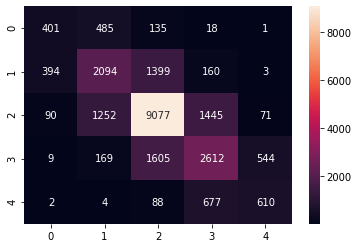

--------------------------------------------------------------------




In [ ]:
confusion_matrix(model, test_iter, loss_function)

In [ ]:
# Plot train and test accuracy and losses

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(f'./data/Sentiment_models/model3/glove_Results_50.csv')
df.head()

,Unnamed: 0,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy
0,0,1.0,1.023642,0.571548,0.963294,0.597684
1,1,2.0,0.943470,0.601555,0.919446,0.613663
2,2,3.0,0.893012,0.620441,0.881764,0.628695
3,3,4.0,0.844951,0.640888,0.855562,0.643472
4,4,5.0,0.798994,0.659634,0.839078,0.652088


In [ ]:
train_loss = df['Train Loss'].values
train_acc = df['Train Accuracy'].values
val_loss = df['Val Loss'].values
val_acc = df['Val Accuracy'].values

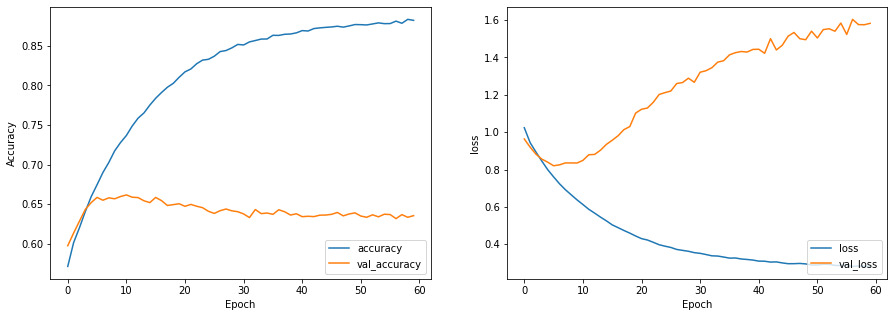

In [ ]:
fig,(ax1,ax2) =  plt.subplots(1,2,figsize=(15,5))

ax1.plot(train_acc, label='accuracy')
ax1.plot(val_acc, label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

ax2.plot(train_loss, label='loss')
ax2.plot(val_loss, label = 'val_loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('loss')
ax2.legend(loc='lower right')

plt.show()

In [ ]:
# comparison over all the three

In [ ]:
df = pd.read_csv(f'./data/Sentiment_models/model3/glove_Results_50.csv')
df.tail()

,Unnamed: 0,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy
55,55,56.0,0.288608,0.877974,1.522746,0.637020
56,56,57.0,0.281305,0.881066,1.603484,0.631873
57,57,58.0,0.283829,0.878355,1.575525,0.636954
58,58,59.0,0.281593,0.883300,1.574608,0.633569
59,59,60.0,0.281958,0.882047,1.582253,0.635654


In [ ]:
df = pd.read_csv(f'./data/Sentiment_models/model2/glove_Results_200.csv')
df.tail()

,Unnamed: 0,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy
55,55,56.0,0.185815,0.917685,1.905004,0.637191
56,56,57.0,0.186713,0.915632,1.976784,0.635856
57,57,58.0,0.186120,0.916946,1.948507,0.634240
58,58,59.0,0.186801,0.915301,1.987794,0.636014
59,59,60.0,0.185436,0.916163,1.886809,0.635716


In [ ]:
df = pd.read_csv(f'./data/Sentiment_models/model1/glove_Results_100.csv')
df.tail()

,Unnamed: 0,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy
55,55,56.0,0.224905,0.901498,1.705615,0.636252
56,56,57.0,0.224864,0.901504,1.749341,0.635348
57,57,58.0,0.224450,0.902687,1.793063,0.637348
58,58,59.0,0.223644,0.901566,1.726801,0.633000
59,59,60.0,0.221621,0.901586,1.749967,0.637148


In [ ]:
train_loss = [0.185436, 0.221621, 0.281958]
train_acc = [0.916163, 0.901586, 0.882047]
val_loss = [1.886809, 1.74996, 1.582253]
val_acc = [0.635716, 0.637148, 0.635654]

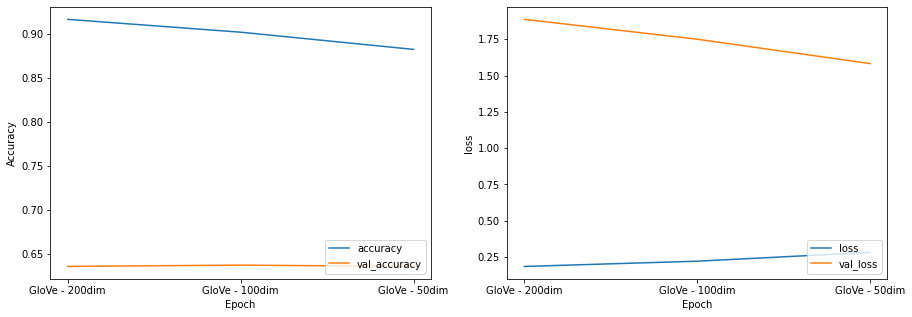

In [ ]:
fig,(ax1,ax2) =  plt.subplots(1,2,figsize=(15,5))
x = ['GloVe - 200dim', 'GloVe - 100dim','GloVe - 50dim']
ax1.plot(x, train_acc, label='accuracy')
ax1.plot(x, val_acc, label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

ax2.plot(x, train_loss, label='loss')
ax2.plot(x, val_loss, label = 'val_loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('loss')
ax2.legend(loc='lower right')

plt.show()